In [1]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data/min_gpt_big_bpe'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_bert_base_cased'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'bert-base-cased'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

Building the model


In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A1', 1: 'A12', 2: 'A7', 3: 'A16', 4: 'A8', 5: 'A22', 6: 'A4', 7: 'A11', 8: 'A14', 9: 'A9', 10: 'A17'}
dict_values(['A1', 'A12', 'A7', 'A16', 'A8', 'A22', 'A4', 'A11', 'A14', 'A9', 'A17'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 0
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

0


<All keys matched successfully>

### Data loading

In [7]:
en_test_df = pd.read_csv(pathjoin(DATA_DIR, 'en_topic'))
en_test_df.head()

,Unnamed: 0,target,text,topic
0,0,A4,"guitar . This part of the facts , however , di...",music
1,1,A4,"bandits , the most powerful members who were c...",music
2,2,A4,jazz poems . Deppily published Stanley and Mic...,music
3,3,A4,songs of it to make it . If there was any chan...,music
4,4,A4,"guitar , and his teeth . "" I ' ll give you the...",music


In [8]:
true_classes = en_test_df.target.values
sentences = en_test_df.text.values

### Preliminary analysis

In [9]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [10]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [11]:
print(len(np.unique(true_classes)))

11


In [12]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.7522123893805311 precision 0.85 recall 0.6746031746031746
label (fictive) f1_score 0.9458128078817734 precision 0.96 recall 0.9320388349514563
label (instruct) f1_score 0.8611111111111112 precision 0.93 recall 0.8017241379310345
label (reporting) f1_score 0.7040816326530612 precision 0.69 recall 0.71875
label (legal) f1_score 0.877005347593583 precision 0.82 recall 0.9425287356321839
label (personal) f1_score 0.7116104868913858 precision 0.95 recall 0.5688622754491018
label (commercial) f1_score 0.5951219512195122 precision 0.61 recall 0.580952380952381
label (research) f1_score 0.8044692737430168 precision 0.72 recall 0.9113924050632911
label (info) f1_score 0.48372093023255813 precision 0.52 recall 0.45217391304347826
label (eval) f1_score 0.6627906976744186 precision 0.57 recall 0.7916666666666666
label (stuff) f1_score 0.417910447761194 precision 0.28 recall 0.8235294117647058
accuracy 0.7181818181818181


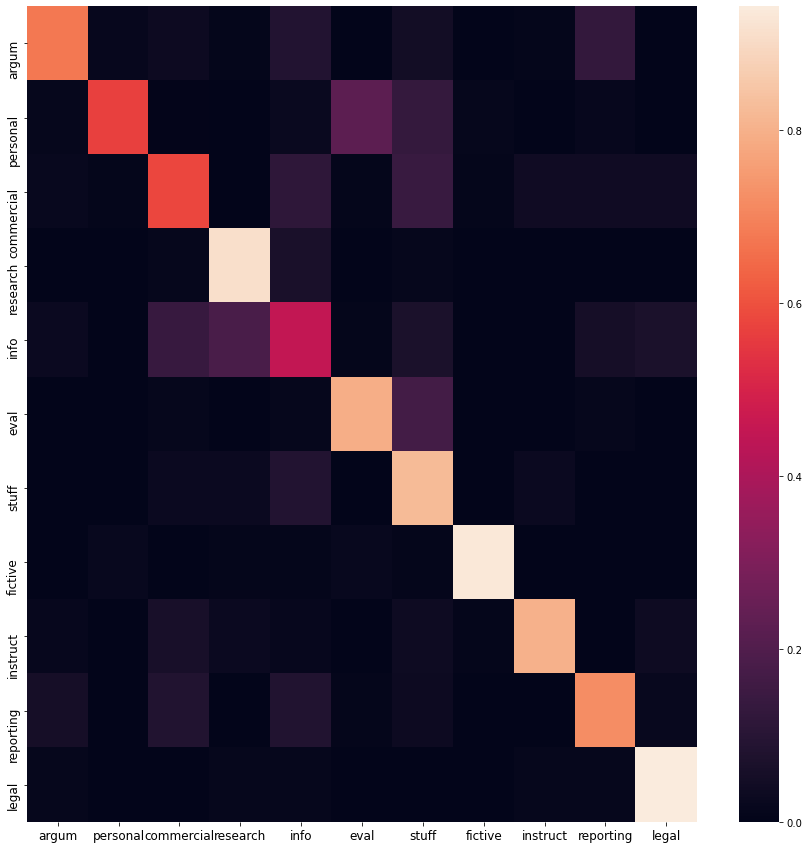

In [13]:
plot_confusion_matrix(predicted_classes, true_classes)

### Topic analysis

In [14]:
def analyze_topics(topic_df, predicted_classes):
    count_by_topic, correct_count_by_topic = dict(), dict()
    
    for item_id, predicted_class in enumerate(predicted_classes):
        topic = topic_df.topic.values[item_id]
        true_class = topic_df.target.values[item_id]
        if topic not in count_by_topic:
            correct_count_by_topic[topic] = count_by_topic[topic] = 0
        count_by_topic[topic] += 1
        correct_count_by_topic[topic] += (predicted_class == true_class)
        
    for topic, count in count_by_topic.items():
        print("topic:", topic)
        print("accuracy:", correct_count_by_topic[topic] / count)

In [15]:
analyze_topics(en_test_df, predicted_classes)

topic: music
accuracy: 0.7090909090909091
topic: education
accuracy: 0.6909090909090909
topic: politics
accuracy: 0.7181818181818181
topic: sport
accuracy: 0.7454545454545455
topic: business
accuracy: 0.6818181818181818
topic: literature
accuracy: 0.7272727272727273
topic: crime
accuracy: 0.7363636363636363
topic: travel
accuracy: 0.7454545454545455
topic: games
accuracy: 0.7272727272727273
topic: arhitecture
accuracy: 0.7
